<a href="https://colab.research.google.com/github/blid11/Group9/blob/Brett/G9_PartC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes made in this Colab notebook can be saved with Control/Command S and do not need to be pushed to Github. 
Also apparently SVM is a better model for classifying than the PCA/neural network I was trying below.

In [1]:

# Import libaries needed
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My Drive/G9A2/G9
 
#%cd gdrive/My Drive/G9A2
# I made a folder on my google drive that has the G9 Methylation data and the binfpy library
#this code automatically loads it in
# you can do the same with your google drive. 
# restart runtime if you experience errors!

Mounted at /content/gdrive
/content/gdrive/My Drive/G9A2/G9


# Data Preparation


In [ ]:
!ls

G9_liver_dna-meth.csv	mystery_dna-meth.csv
G9_liver_gene-expr.csv	mystery_gene-expr.csv


In [3]:
# load the data 
liver_meth_dna = pd.read_csv('G9_liver_dna-meth.csv')
liver_gene_expr = pd.read_csv('G9_liver_gene-expr.csv')



In [ ]:
# view the data: 
liver_meth_dna.head(n = 5)
liver_gene_expr.shape

(421, 19938)

In [ ]:
liver_gene_expr.head(n= 5)
#the first column is sample
#the second column is the Label 
# the third column onwards are Data (expression values for given gene)

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,0.0,1.5051,3.7074,90.1124,1017.1038,0.0,141.3911,0.6516,...,24.7597,273.6602,794.2662,18.2440,499.1041,3172.5037,890.0472,510.1808,3.9094,6.5157
1,TCGA.2Y.A9GS.01,Primary Tumor,0.0,26.4120,2.6663,71.0054,639.2311,0.0,122.7206,1.4786,...,68.5067,632.8241,1153.7703,71.4638,1000.4929,5301.1336,755.5446,860.5224,6.4071,482.9966
2,TCGA.2Y.A9GT.01,Primary Tumor,0.0,0.0000,4.4833,95.5122,742.4344,0.0,95.0460,1.7933,...,46.6263,1219.4575,1133.3782,12.5532,1289.3970,3219.0092,860.7935,523.6494,14.3466,83.3894
3,TCGA.2Y.A9GU.01,Primary Tumor,0.0,5.7222,5.1216,61.6679,1186.9807,0.0,280.2709,0.8341,...,18.3511,285.2758,1150.2786,9.1755,941.7437,3092.9899,1339.6283,343.6655,2.5024,2.5024
4,TCGA.2Y.A9GV.01,Primary Tumor,0.0,11.4975,5.4230,104.4670,878.1726,0.0,282.5719,0.0000,...,41.4552,999.1540,1631.9797,4.2301,1380.7107,2902.7073,575.2961,665.8206,2.5381,119.2893


will be creating two models: one for gene expression and one for methylation
so will not merge the two datasets 
we can use the same model architecture and train it on different data

standardizing and log transforming data relatively standard for gene expression data
and probably for methylation data as well 




(421, 19547)


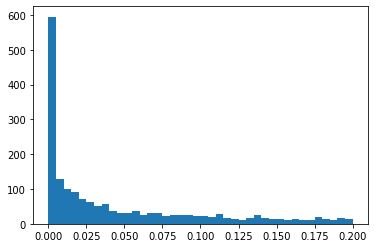

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..155060,X..26823,X..280660,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,0.263113,1.214289,-0.419556,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,0.114870,2.651003,-0.419556,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


In [4]:
# standardizing and log transform data prior to PCA
# for each numeric value column in the dataframem, normalize 
# and log tranform the values


col_names_exp = liver_gene_expr.columns
col_names_meth = liver_meth_dna.columns

#replace Inf and Nan with 0
#liver_gene_expr.replace([np.inf, -np.inf], 0, inplace=True)
#liver_meth_dna.replace([np.inf,-np.inf], 0, inplace=True)

expr_means = []

for column in liver_gene_expr[col_names_exp[2:]]:
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex ='[^0-9.]', value = "d") 
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex = 'd{10}]', value = "d") 
  col_mean = liver_gene_expr[column].mean()
  expr_means.append(col_mean)
  if col_mean > 0.025:
    liver_gene_expr[column] = liver_gene_expr[column].replace([np.inf, np.nan, -np.inf], col_mean)
  else: 
    liver_gene_expr = liver_gene_expr.drop(column, axis = 1)
  #liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

print(liver_gene_expr.shape)

plt.hist(expr_means, bins = 40, range = [0.0, 0.2])
plt.show()

col_names_exp = liver_gene_expr.columns
col_names_meth = liver_meth_dna.columns

for column in liver_meth_dna[col_names_meth[2:]]: 
  col_mean = liver_meth_dna[column].mean()
  liver_meth_dna[column] = liver_meth_dna[column].replace([np.inf, np.nan, -np.inf], col_mean)
  liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

#Normalize and log tranform data for both sets
for col_name in col_names_exp[2:]:
  col_data = pd.to_numeric(np.log2(liver_gene_expr[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_gene_expr[col_name] = new_data

for col_name in col_names_meth[2:]:
  col_data = pd.to_numeric(np.log2(liver_meth_dna[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_meth_dna[col_name] = new_data

liver_gene_expr.head(n= 2)


In [ ]:
liver_gene_expr.head(n = 2)

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,-0.067789,0.263113,1.214289,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,-0.067789,0.114870,2.651003,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


May want to also try to remove duplicates and balance out the number of each class. 

# Gene Expression SVM


[[-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 [-0.25592957  0.65613272  0.47502188 ... -1.18261389 -0.36448635
  -1.40671968]]
False
[[-0.25592957 -0.47616495  0.13462249 ... -0.13217872 -0.01159508
  -0.96279728]
 [-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 ...
 [-0.25592957 -1.5295894   1.07851796 ...  0.19584219 -1.67430781
   0.67506188]
 [-0.25592957  0.90347699  1.2214136  ...  1.18408463 -0.29124152
   0.67193626]
 [-0.25592957 -1.5295894   1.00660325 ...  0.39696149  0.27911813
   0.61519723]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


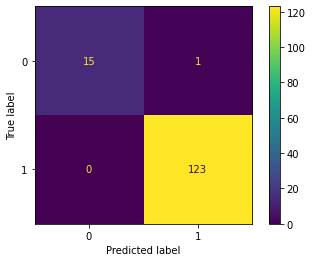

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9928057553956835
Precision: 0.9928637734973311
Recall: 0.9928057553956835
Training set Accuracy: 0.9964539007092199
Training set Precision: 0.9965552178318136
Training set Recall: 0.9964539007092199


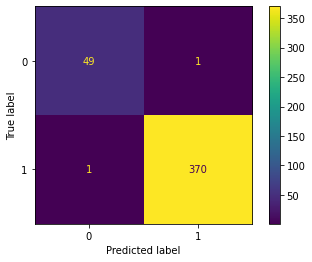

In [5]:
## Encode the labels in 1 hot encoding
from sklearn import svm, metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.impute import SimpleImputer

# convert labels to 1 or 0 
bool_tum_expr = [1 if value == 'Primary Tumor' else 0 for value in liver_gene_expr['Label'].values]
bool_tum_meth = [1 if value == 'Primary Tumor' else 0 for value in liver_meth_dna['Label'].values]

exp_enc = LabelEncoder()
exp_enc.fit(bool_tum_expr)
encoded_Y = exp_enc.transform(bool_tum_expr)
# convert integers to dummy variables (i.e. one hot encoded)

#sklearn's SimpleImputer can replace the missing values in a column
#with the columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]])
print(exp_data[1:4,:])

print(np.any(np.isnan(exp_data)))
print(exp_data)
X_train, X_test, y_train, y_test = train_test_split(exp_data, bool_tum_expr, test_size=0.33, random_state=42)

# Run a SVM
# https://scikit-learn.org/stable/modules/svm.html
clf_tumours = svm.SVC(kernel='rbf')
clf_tumours.fit(X_train, y_train)
plot_confusion_matrix(clf_tumours, X_test, y_test)  
plt.show()
plot_confusion_matrix(clf_tumours, exp_data, bool_tum_expr) 

y_pred = clf_tumours.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

y_pred_train = clf_tumours.predict(X_train)
# Model Accuracy: how often is the classifier correct?
print("Training set Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Training set Precision:",metrics.precision_score(y_train, y_pred_train, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Training set Recall:",metrics.recall_score(y_train, y_pred_train, average='weighted'))

# Gene Expression SVM - Mystery Data


In [ ]:

mys_meth_dna = pd.read_csv('mystery_dna-meth.csv')
mys_gene_expr = pd.read_csv('mystery_gene-expr.csv')
col_names_exp_mys = mys_gene_expr.columns
col_names_meth_mys = mys_meth_dna.columns

(421, 19547)


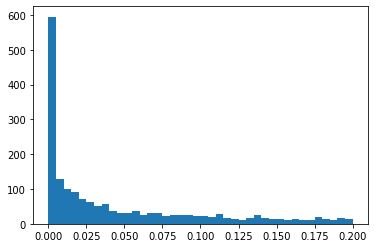

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..155060,X..26823,X..280660,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,0.263113,1.214289,-0.419556,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,0.114870,2.651003,-0.419556,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


In [ ]:
# standardizing and log transform data prior to PCA
# for each numeric value column in the dataframem, normalize 
# and log tranform the values

expr_means = []

mys_gene_expr = mys_gene_expr[mys_gene_expr['Label'].notna()]

# convert labels to 1 or 0 
bool_tum_expr_mys = [1 if value == 'Primary Tumor' else 0 for value in liver_gene_expr['Label'].values]

for column in mys_gene_expr[col_names_exp_mys[2:]]:
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex ='[^0-9.]', value = "d") 
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex = 'd{10}]', value = "d") 
  col_mean = mys_gene_expr[column].mean()
  expr_means.append(col_mean)
  if col_mean > 0.025:
    mys_gene_expr[column] = mys_gene_expr[column].replace([np.inf, np.nan, -np.inf], col_mean)
  else: 
    mys_gene_expr = mys_gene_expr.drop(column, axis = 1)
  #liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

print(mys_gene_expr.shape)

plt.hist(expr_means, bins = 40, range = [0.0, 0.2])
plt.show()

col_names_exp_mys = mys_gene_expr.columns


#Normalize and log tranform data for both sets
for col_name in col_names_exp_mys[2:]:
  col_data = pd.to_numeric(np.log2(mys_gene_expr[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  mys_gene_expr[col_name] = new_data


mys_gene_expr.head(n= 2)

#Impute
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mys_exp_data = imp.fit_transform(mys_gene_expr[col_names_exp_mys[2:]])
print(exp_data[1:4,:])


[[-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 [-0.25592957  0.65613272  0.47502188 ... -1.18261389 -0.36448635
  -1.40671968]]
False
[[-0.25592957 -0.47616495  0.13462249 ... -0.13217872 -0.01159508
  -0.96279728]
 [-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 ...
 [-0.25592957 -1.5295894   1.07851796 ...  0.19584219 -1.67430781
   0.67506188]
 [-0.25592957  0.90347699  1.2214136  ...  1.18408463 -0.29124152
   0.67193626]
 [-0.25592957 -1.5295894   1.00660325 ...  0.39696149  0.27911813
   0.61519723]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


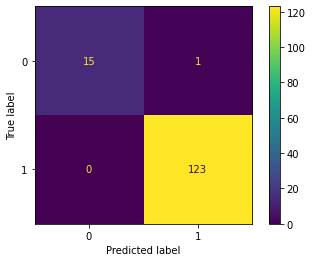

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9928057553956835
Precision: 0.9928637734973311
Recall: 0.9928057553956835
Training set Accuracy: 0.9964539007092199
Training set Precision: 0.9965552178318136
Training set Recall: 0.9964539007092199


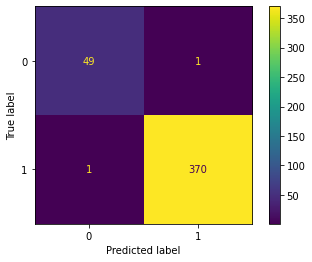

In [ ]:


exp_enc = LabelEncoder()
exp_enc.fit(bool_tum_expr)
encoded_Y = exp_enc.transform(bool_tum_expr)
# convert integers to dummy variables (i.e. one hot encoded)


y_pred = clf_tumours.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

y_pred_train = clf_tumours.predict(X_train)
# Model Accuracy: how often is the classifier correct?
print("Training set Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Training set Precision:",metrics.precision_score(y_train, y_pred_train, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Training set Recall:",metrics.recall_score(y_train, y_pred_train, average='weighted'))

# PCA

Alternatively, one could perform PCA on the data to determine which features are most important to reduce dimensionality prior to training an SVM or a neural network.

True
(20531, 20)


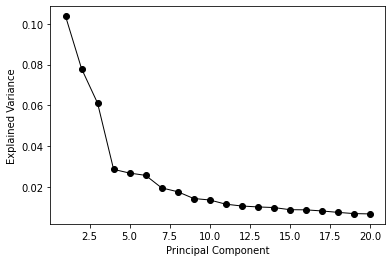

[0.10370629 0.07798418 0.06108182 0.02861618 0.02679588 0.02567671
 0.0195272  0.01766106 0.01432843 0.01360874 0.01155351 0.010653
 0.01019934 0.00990339 0.00885247 0.00877028 0.00822711 0.00753337
 0.00693344 0.00677224]


In [ ]:
# Using PCA
# turn into PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print(liver_gene_expr.isnull().values.any())

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]].T)

#scale the data
scaler = StandardScaler()
scaler.fit(exp_data)
exp_data=scaler.transform(exp_data) 

#print(liver_gene_expr.apply(pd.isna).all())

#try 10 components or more
exp_pca = PCA(n_components=20)
exp_pc_data = exp_pca.fit_transform(exp_data)

print(exp_pc_data.shape)

PC_values = np.arange(exp_pca.n_components_) + 1
plt.plot(PC_values, exp_pca.explained_variance_ratio_, 'o-', linewidth=1, color='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(exp_pca.explained_variance_ratio_)

# 


Convolutional Neural Network Gene Expression

In [ ]:

#first clean and scale the data
col_names_exp_CNN = col_names_exp
liver_gene_expr_nn = liver_gene_expr.copy()
liver_gene_expr_nn[col_names_exp[2:]] = imp.fit_transform(liver_gene_expr_nn[col_names_exp[2:]])
for new_col in range(205): 
  liver_gene_expr_nn["AddC" + str(new_col)] = np.zeroes((421, 1))
  col_names_exp_CNN.append("AddC" + str(new_col))

exp_data_CNN = []
exp_lab_CNN = []
lab_index = 0
#the closest perfect square to 20531 is 20736, therefore 20736 -20531 additional columns required 
for index, row in liver_gene_expr_nn:
  #take the row and turn it into a 144 x 144 nparray
  sample_data = row[col_names_exp_CNN[2:]].values
  #rescale to between 0 and 255
  sample_data *= (255.0/sample_data.max())
  sample_data = np.reshape(sample_data, (144,144))
  exp_data_CNN.append(sample_data)
  exp_lab_CNN.append(bool_tum_expr[lab_index])
  lab_index += 1

exp_data_CNN = np.asarray(exp_data_CNN)
exp_lab_CNN = np.asarray(exp_data_CNN)

np.save('exp_data.npy', exp_data_CNN)
np.save('exp_labels.npy', exp_lab_CNN)

ValueError: ignored

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
# TAKEN FROM WEBSITE, NEED TO CHANGE: 
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

exp_CNN_model = define_model()
#datagen = ImageDataGenerator(rescale=1.0/255.0)

X_train, X_test, y_train, y_test = train_test_split(exp_data_CNN, exp_lab_CNN, test_size=0.33, random_state=42)

exp_CNN_model.fit(X_train, y_train, batch_size=32, epochs=10)

# TensorBoard for Model Evaluation

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir /dir/

# or use %tensorboard --logdir /dir/

# JUST reference info below here

# Neural Network


In [ ]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train, X_test, y_train, y_test = train_test_split(exp_pc_data, bool_tum_expr, test_size=0.33, random_state=42)
# create model

model = Sequential()
model.add(Dense(2,  activation='sigmoid', input_shape=(3,),  name="bottleneck"))
model.add(Dense(3,  activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 150, batch_size = 4)

ValueError: ignored

In [ ]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))